# Mise en place

# Installations des differentes librairies pour executer notre projet

In [1]:
!pip install pandas scikit-learn tqdm seaborn captum torchcam

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 39.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 2.6 MB/s eta 0:00:00


# Importations des fonctions utilisees dans les differentes librairies

In [2]:
import os

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.cm as cm
import numpy as np
from tqdm import tqdm
from time import time
import seaborn as sn

# importing pytorch libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
#import torchvision.models as models
import torch.nn.functional as F
from torchvision.transforms import v2 as transforms
from torchvision.models import resnet18, ResNet18_Weights
from torch.utils.data import Dataset
from torchvision.io import read_image
from torchvision.transforms.functional import to_pil_image, normalize, resize
from torchcam.methods import SmoothGradCAMpp

# importing image required libraries
import PIL.Image as Image
from IPython.display import display
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import joblib

from captum.attr import IntegratedGradients
from captum.attr import GradientShap
from captum.attr import LRP
from captum.attr import Occlusion
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz
from captum.attr._utils.lrp_rules import EpsilonRule, GammaRule, Alpha1_Beta0_Rule

In [3]:
# Adding a seed to ensure reproducibility of results
seed = 12345
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [4]:
# Dataset
local_path = '/kaggle/input/stanford-car-dataset-by-classes-folder/car_data/car_data'

# Annotation and class names
anno_train_path = "/kaggle/input/stanford-car-dataset-by-classes-folder/anno_train.csv"
anno_test_path = "/kaggle/input/stanford-car-dataset-by-classes-folder/anno_test.csv"
class_names_path = "/kaggle/input/stanford-car-dataset-by-classes-folder/names.csv"

# Path to the weigths
model_path = '/kaggle/working/model.pth'

# Folder to save the false positives 
false_images_folder_path = "/kaggle/working/false_images/"
false_images_heatmap_folder_path = "/kaggle/working/false_images_with_heatmap/"

# Dataset

In [5]:
# creating a dictionary of the classes and counting the number of images in each class by iterating through the folders
car_count_dict = {}
for folder_name in os.listdir(os.path.join(local_path, 'train')):
    count = len(os.listdir(os.path.join(local_path, 'train', folder_name)))
    car_count_dict[folder_name] = count

for folder_name in os.listdir(os.path.join(local_path, 'test')):
    count = len(os.listdir(os.path.join(local_path, 'test', folder_name)))
    car_count_dict[folder_name] += count

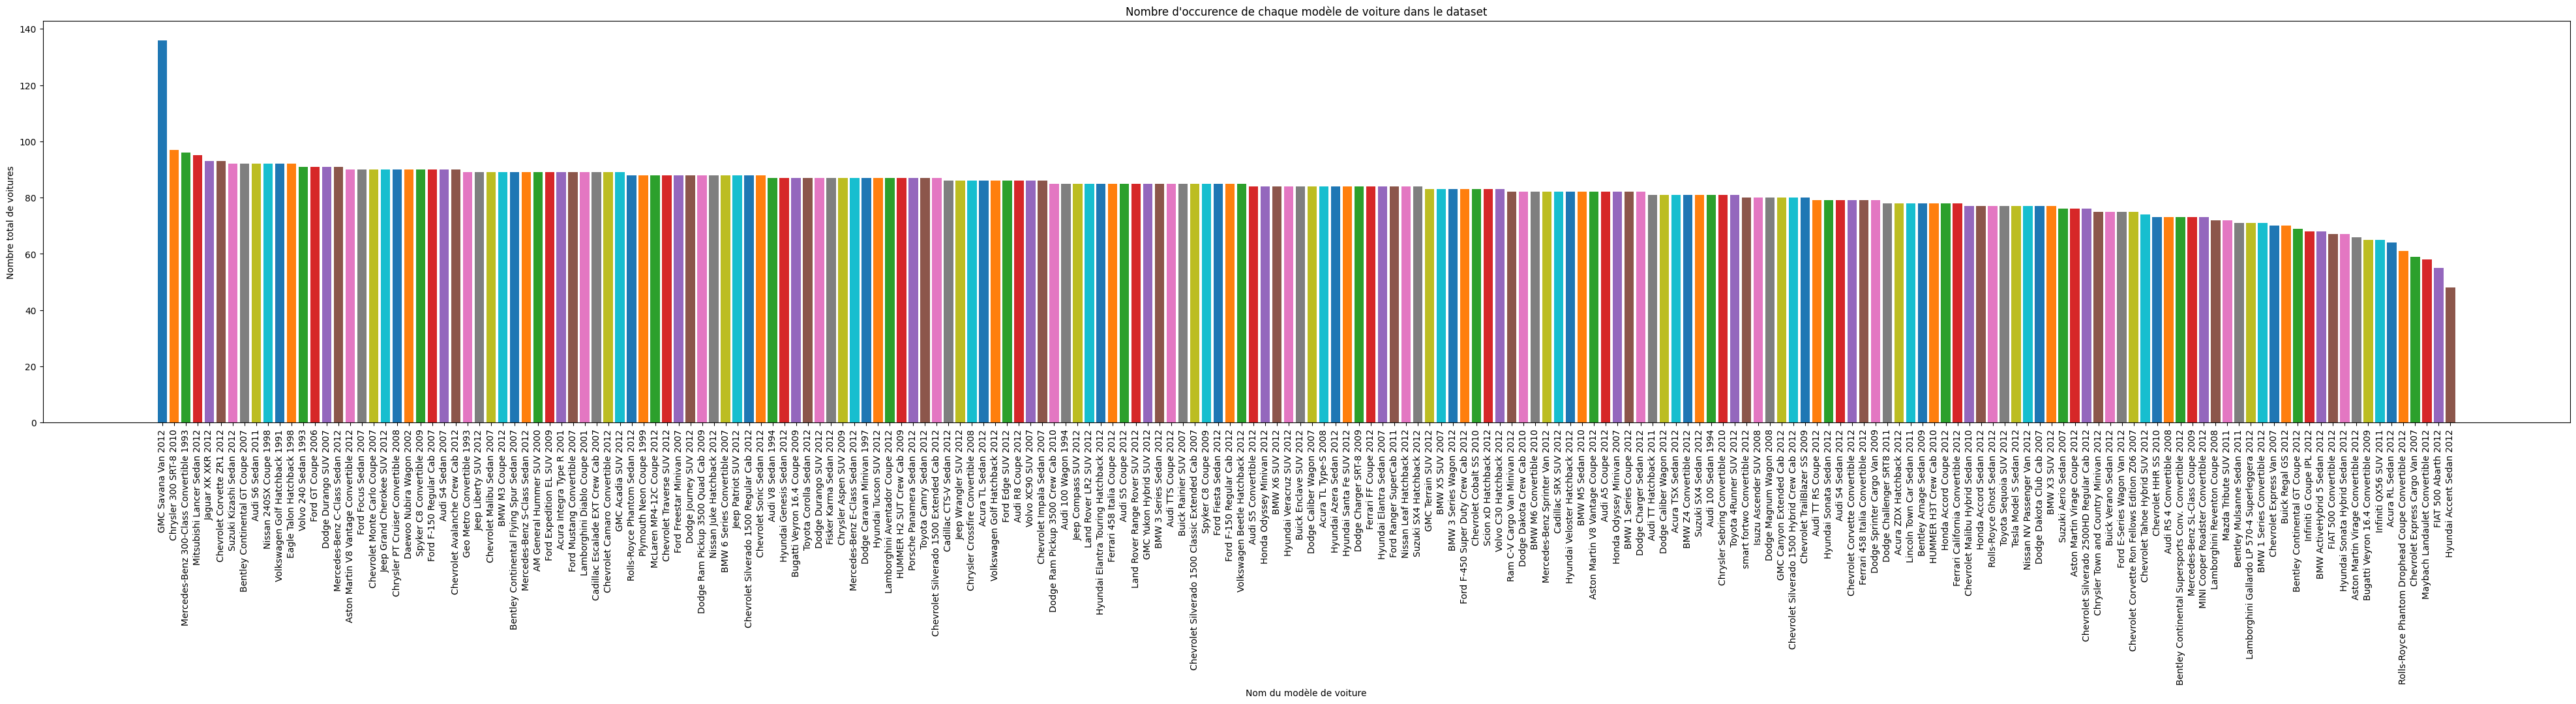

In [6]:
# Assuming car_count_dict is already defined with your data
sorted_car_count = sorted(car_count_dict.items(), key=lambda x: x[1], reverse=True)
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

# Create a figure with a specific size
plt.figure(figsize=(50, 8))

# Create a bar chart
plt.bar([x[0] for x in sorted_car_count], [x[1] for x in sorted_car_count], color=colors)

# Add labels and title
plt.xlabel('Nom du modèle de voiture')
plt.ylabel('Nombre total de voitures')
plt.title('Nombre d\'occurence de chaque modèle de voiture dans le dataset')

# Rotate x-axis labels for better visibility
plt.xticks(rotation=90)

# Save the figure before showing it
plt.savefig('car_count.png')

# Display the histogram
plt.show()

In [7]:
#Load csv
df_train = pd.read_csv(anno_train_path, header=None, names=['path', '1', '2', '3', '4', "label"])
df_test = pd.read_csv(anno_test_path, header=None, names=['path', '1', '2', '3', '4', "label"])
df_names = pd.read_csv(class_names_path, header=None, names=["classe_name"])

#Some classes name have "/" in it, put folder have "-" instead

classes = df_names.to_numpy().astype(str)
classes = [ np.char.replace(i, "/", "-") for i in classes]
print(str(len(classes)) + " classes found")

#get path for each image
def path_join(X, y, mode):
    return [os.path.join(local_path, mode, classes[label ][0], path) for (path, label) in zip(X,y)]

#Merge both annotation

X = df_train.iloc[:, 0].to_numpy()
y = df_train.iloc[:, -1].to_numpy() - 1
X = path_join(X,y,"train")
X_test = df_test.iloc[:, 0].to_numpy()
y_test = df_test.iloc[:, -1].to_numpy() - 1
X_test = path_join(X_test, y_test, "test")
X = np.concatenate((X,X_test ), axis= 0) 
y = np.concatenate((y, y_test), axis=0)

# Premier split pour diviser en train et temporaire (test + val)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)

# Second split pour diviser le temporaire en test et val
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.7, random_state=42)

196 classes found


In [8]:
class CarDataset(Dataset):
    def __init__(self,image_paths, labels, transform=None):
        """
        Args:
            image_paths (list): Liste des chemins relatifs vers les images.
            labels (list): Liste des étiquettes correspondantes aux images.
            transform (callable, optional): Transformations optionnelles à appliquer sur les images (ex. transformations de torchvision).
        """
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):

        
        full_image_path = self.image_paths[idx]
        image = Image.open(full_image_path)
        
        if self.transform:
            image = self.transform(image)
        label = self.labels[idx]

        
        return image, label

# Data transformation

In [9]:
# Create transform function
train_tfms = transforms.Compose([
    transforms.Resize((256, 256)),   #must same as here
    transforms.CenterCrop((224,224)),
    transforms.RandomHorizontalFlip(), # data augmentation
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # normalization
])
test_tfms = transforms.Compose([
    transforms.Resize((256, 256)),   #must same as here
    transforms.CenterCrop((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [10]:
batch_size = 16

# defining the dataset from the image folder 
# Here we use the folder names themselves as the class names
train_dataset = CarDataset(X_train, y_train, transform = train_tfms)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle=True, num_workers=4)

test_dataset = CarDataset(X_test, y_test,transform = test_tfms)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size, shuffle=False, num_workers=4)

val_dataset = CarDataset(X_val, y_val, transform = test_tfms)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size = batch_size, shuffle=False, num_workers=4)

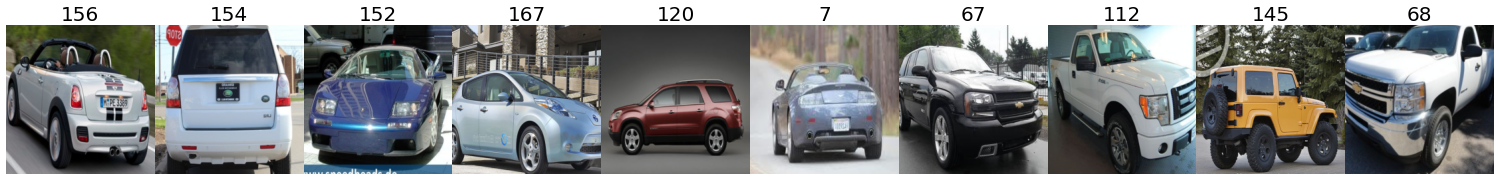

In [11]:
plt.rcParams['figure.figsize'] = [32, 32]  # size for bigger images
plt.rcParams['figure.dpi'] = 60
plt.rcParams.update({'font.size': 20})

def imshow(input, class_indices):
    num_images = len(input)
    fig, axes = plt.subplots(1, num_images)
    fig.subplots_adjust(wspace=0)  # Set the horizontal space between subplots to 0
    for ax, img, index in zip(axes.ravel(), input, class_indices):
        # torch.Tensor => numpy
        img = img.numpy().transpose((1, 2, 0))
        # undo image normalization
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = std * img + mean
        img = np.clip(img, 0, 1)
        # display image
        ax.imshow(img)
        ax.set_title(f"{index}")
        ax.axis('off')
    
    # Remove empty subplots if necessary
    for ax in axes.ravel():
        if not ax.images:
            ax.axis('off')
    plt.show()

# load a batch of train image
iterator = iter(train_loader)
# visualize a batch of train image
inputs, classes_tmp = next(iterator)
imshow(inputs[:10], classes_tmp[:10])

# Model ResNet18

In [12]:
model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
num_features = model.fc.in_features 
model.fc = nn.Linear(num_features, len(classes))
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, threshold = 0.9)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 143MB/s] 


## Training

In [13]:
# Train model
train_loss = []
train_accuracy = []
test_loss = []
test_accuracy = []
def train_model():
    num_epochs = 15
    start_time = time()  # Start time

    # Start loop
    for epoch in range(num_epochs):
        """ Training Phase """
        model.train()  # Set model to training mode
        running_loss = 0.0
        running_corrects = 0

        # Wrap train_loader with tqdm for progress bar
        with tqdm(train_loader, unit="batch") as train_bar:
            for i, (inputs, labels) in enumerate(train_bar):
                train_bar.set_description(f"Epoch {epoch+1}")

                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()  # Zero gradients
                outputs = model(inputs)  # Forward pass
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)  # Calculate loss

                loss.backward()  # Backpropagation
                optimizer.step()  # Update weights

                running_loss += loss.item()
                running_corrects += (labels==preds).sum().item()

        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = 100./batch_size * running_corrects / len(train_loader)

        train_loss.append(epoch_loss)
        train_accuracy.append(epoch_accuracy)

        print('[Train #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch+1, epoch_loss, epoch_accuracy, time() - start_time))

        """ Testing Phase """
        model.eval()  # Set model to evaluation mode
        with torch.no_grad():
            running_loss = 0.
            running_corrects = 0
            total = 0
            for inputs, labels in test_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                total += labels.size(0)
                running_loss += loss.item()
                running_corrects += (preds == labels).sum().item()
            epoch_loss = running_loss / total
            epoch_acc = 100. * running_corrects / total
            # Append result
            test_loss.append(epoch_loss)
            test_accuracy.append(epoch_acc)
            # Print progress
            print('[Test #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch+1, epoch_loss, epoch_acc, time() - start_time))

            model.train()
            scheduler.step(epoch_acc)
    torch.save(model.state_dict(), 'model.pth')
    return model

In [14]:
# Loading model
def load_model():
    # Define the model architecture again
    model = torchvision.models.resnet18(pretrained=False)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, len(classes))  # Adjust the final layer based on your number of classes

    # Load the saved model state
    checkpoint = torch.load('model.pth')
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    model.to(device)
    
    return model

# Recuperation du model si un modele existe deja dans le dossier

Epoch 1: 100%|██████████| 709/709 [00:58<00:00, 12.09batch/s]


[Train #1] Loss: 3.6885 Acc: 20.7687% Time: 58.6567s
[Test #1] Loss: 0.2002 Acc: 28.0000% Time: 74.4944s


Epoch 2: 100%|██████████| 709/709 [00:45<00:00, 15.54batch/s]

[Train #2] Loss: 1.7561 Acc: 52.1421% Time: 120.1158s


[Test #2] Loss: 0.1213 Acc: 50.7941% Time: 132.3322s


Epoch 3: 100%|██████████| 709/709 [00:45<00:00, 15.73batch/s]


[Train #3] Loss: 1.0654 Acc: 69.2084% Time: 177.4063s
[Test #3] Loss: 0.1027 Acc: 59.0882% Time: 190.0304s


Epoch 4: 100%|██████████| 709/709 [00:45<00:00, 15.74batch/s]

[Train #4] Loss: 0.7156 Acc: 78.8346% Time: 235.0823s


[Test #4] Loss: 0.0782 Acc: 68.2353% Time: 247.3286s


Epoch 5: 100%|██████████| 709/709 [00:45<00:00, 15.61batch/s]

[Train #5] Loss: 0.5049 Acc: 84.6439% Time: 292.7467s


[Test #5] Loss: 0.0760 Acc: 69.0882% Time: 304.7808s


Epoch 6: 100%|██████████| 709/709 [00:45<00:00, 15.53batch/s]

[Train #6] Loss: 0.3548 Acc: 89.3512% Time: 350.4326s


[Test #6] Loss: 0.0705 Acc: 71.4706% Time: 362.5596s


Epoch 7: 100%|██████████| 709/709 [00:45<00:00, 15.61batch/s]

[Train #7] Loss: 0.2846 Acc: 91.3082% Time: 407.9838s


[Test #7] Loss: 0.0591 Acc: 76.4412% Time: 420.3803s


Epoch 8: 100%|██████████| 709/709 [00:45<00:00, 15.60batch/s]


[Train #8] Loss: 0.1008 Acc: 97.4436% Time: 465.8236s
[Test #8] Loss: 0.0371 Acc: 84.3529% Time: 478.2075s


Epoch 9: 100%|██████████| 709/709 [00:45<00:00, 15.53batch/s]

[Train #9] Loss: 0.0608 Acc: 98.5279% Time: 523.8558s


[Test #9] Loss: 0.0356 Acc: 84.2353% Time: 536.2489s


Epoch 10: 100%|██████████| 709/709 [00:45<00:00, 15.52batch/s]

[Train #10] Loss: 0.0507 Acc: 98.9598% Time: 581.9251s


[Test #10] Loss: 0.0339 Acc: 85.5294% Time: 594.3015s


Epoch 11: 100%|██████████| 709/709 [00:46<00:00, 15.27batch/s]

[Train #11] Loss: 0.0463 Acc: 99.2066% Time: 640.7260s


[Test #11] Loss: 0.0344 Acc: 85.4118% Time: 652.9208s


Epoch 12: 100%|██████████| 709/709 [00:46<00:00, 15.39batch/s]

[Train #12] Loss: 0.0383 Acc: 99.2683% Time: 698.9984s


[Test #12] Loss: 0.0344 Acc: 85.5882% Time: 710.7740s


Epoch 13: 100%|██████████| 709/709 [00:45<00:00, 15.75batch/s]

[Train #13] Loss: 0.0377 Acc: 99.3917% Time: 755.7874s


[Test #13] Loss: 0.0341 Acc: 85.3824% Time: 767.9878s


Epoch 14: 100%|██████████| 709/709 [00:45<00:00, 15.71batch/s]

[Train #14] Loss: 0.0363 Acc: 99.3389% Time: 813.1240s


[Test #14] Loss: 0.0349 Acc: 85.0882% Time: 825.2609s


Epoch 15: 100%|██████████| 709/709 [00:45<00:00, 15.73batch/s]

[Train #15] Loss: 0.0379 Acc: 99.3036% Time: 870.3365s


[Test #15] Loss: 0.0344 Acc: 85.5588% Time: 882.3351s
model trained


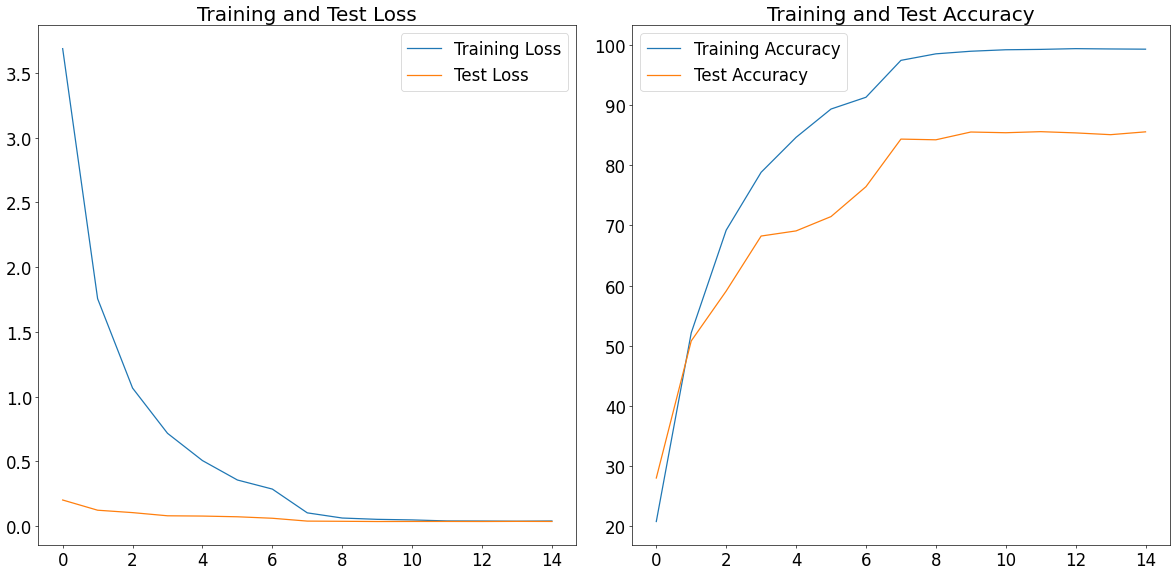

In [15]:
if os.path.exists(model_path):
    model = load_model()
    print("model loaded")
else:
    model = train_model()
    print("model trained")
    fig, axs = plt.subplots(1, 2, figsize=(20, 10))

    # Plot training loss
    axs[0].plot(train_loss,label="Training Loss")
    axs[0].plot(test_loss,label="Test Loss")
    axs[0].set_title("Training and Test Loss")
    axs[0].legend()

    # Plot training and test accuracy
    axs[1].plot(train_accuracy, label="Training Accuracy")
    axs[1].plot(test_accuracy, label="Test Accuracy")
    axs[1].set_title("Training and Test Accuracy")
    axs[1].legend()

    plt.tight_layout()
    plt.show()

In [16]:
# Create empty lists to store the true labels and predicted labels
true_labels = []
predicted_labels = []

# Iterate over the test_loader and generate predictions
with torch.no_grad():
    for images, labels in test_loader:
        # Transfer the images and labels to the device
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images.cuda())
        
        # Get the predicted labels from the maximum value
        _, predicted = torch.max(outputs.data, 1)
        
        # Append the true labels and predicted labels to the lists
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

# Generate the confusion matrix
mc = confusion_matrix(true_labels, predicted_labels)

# Generate the classification report
cr = classification_report(true_labels, predicted_labels, target_names=[i[0] for i in pd.DataFrame(classes).to_numpy().tolist()])

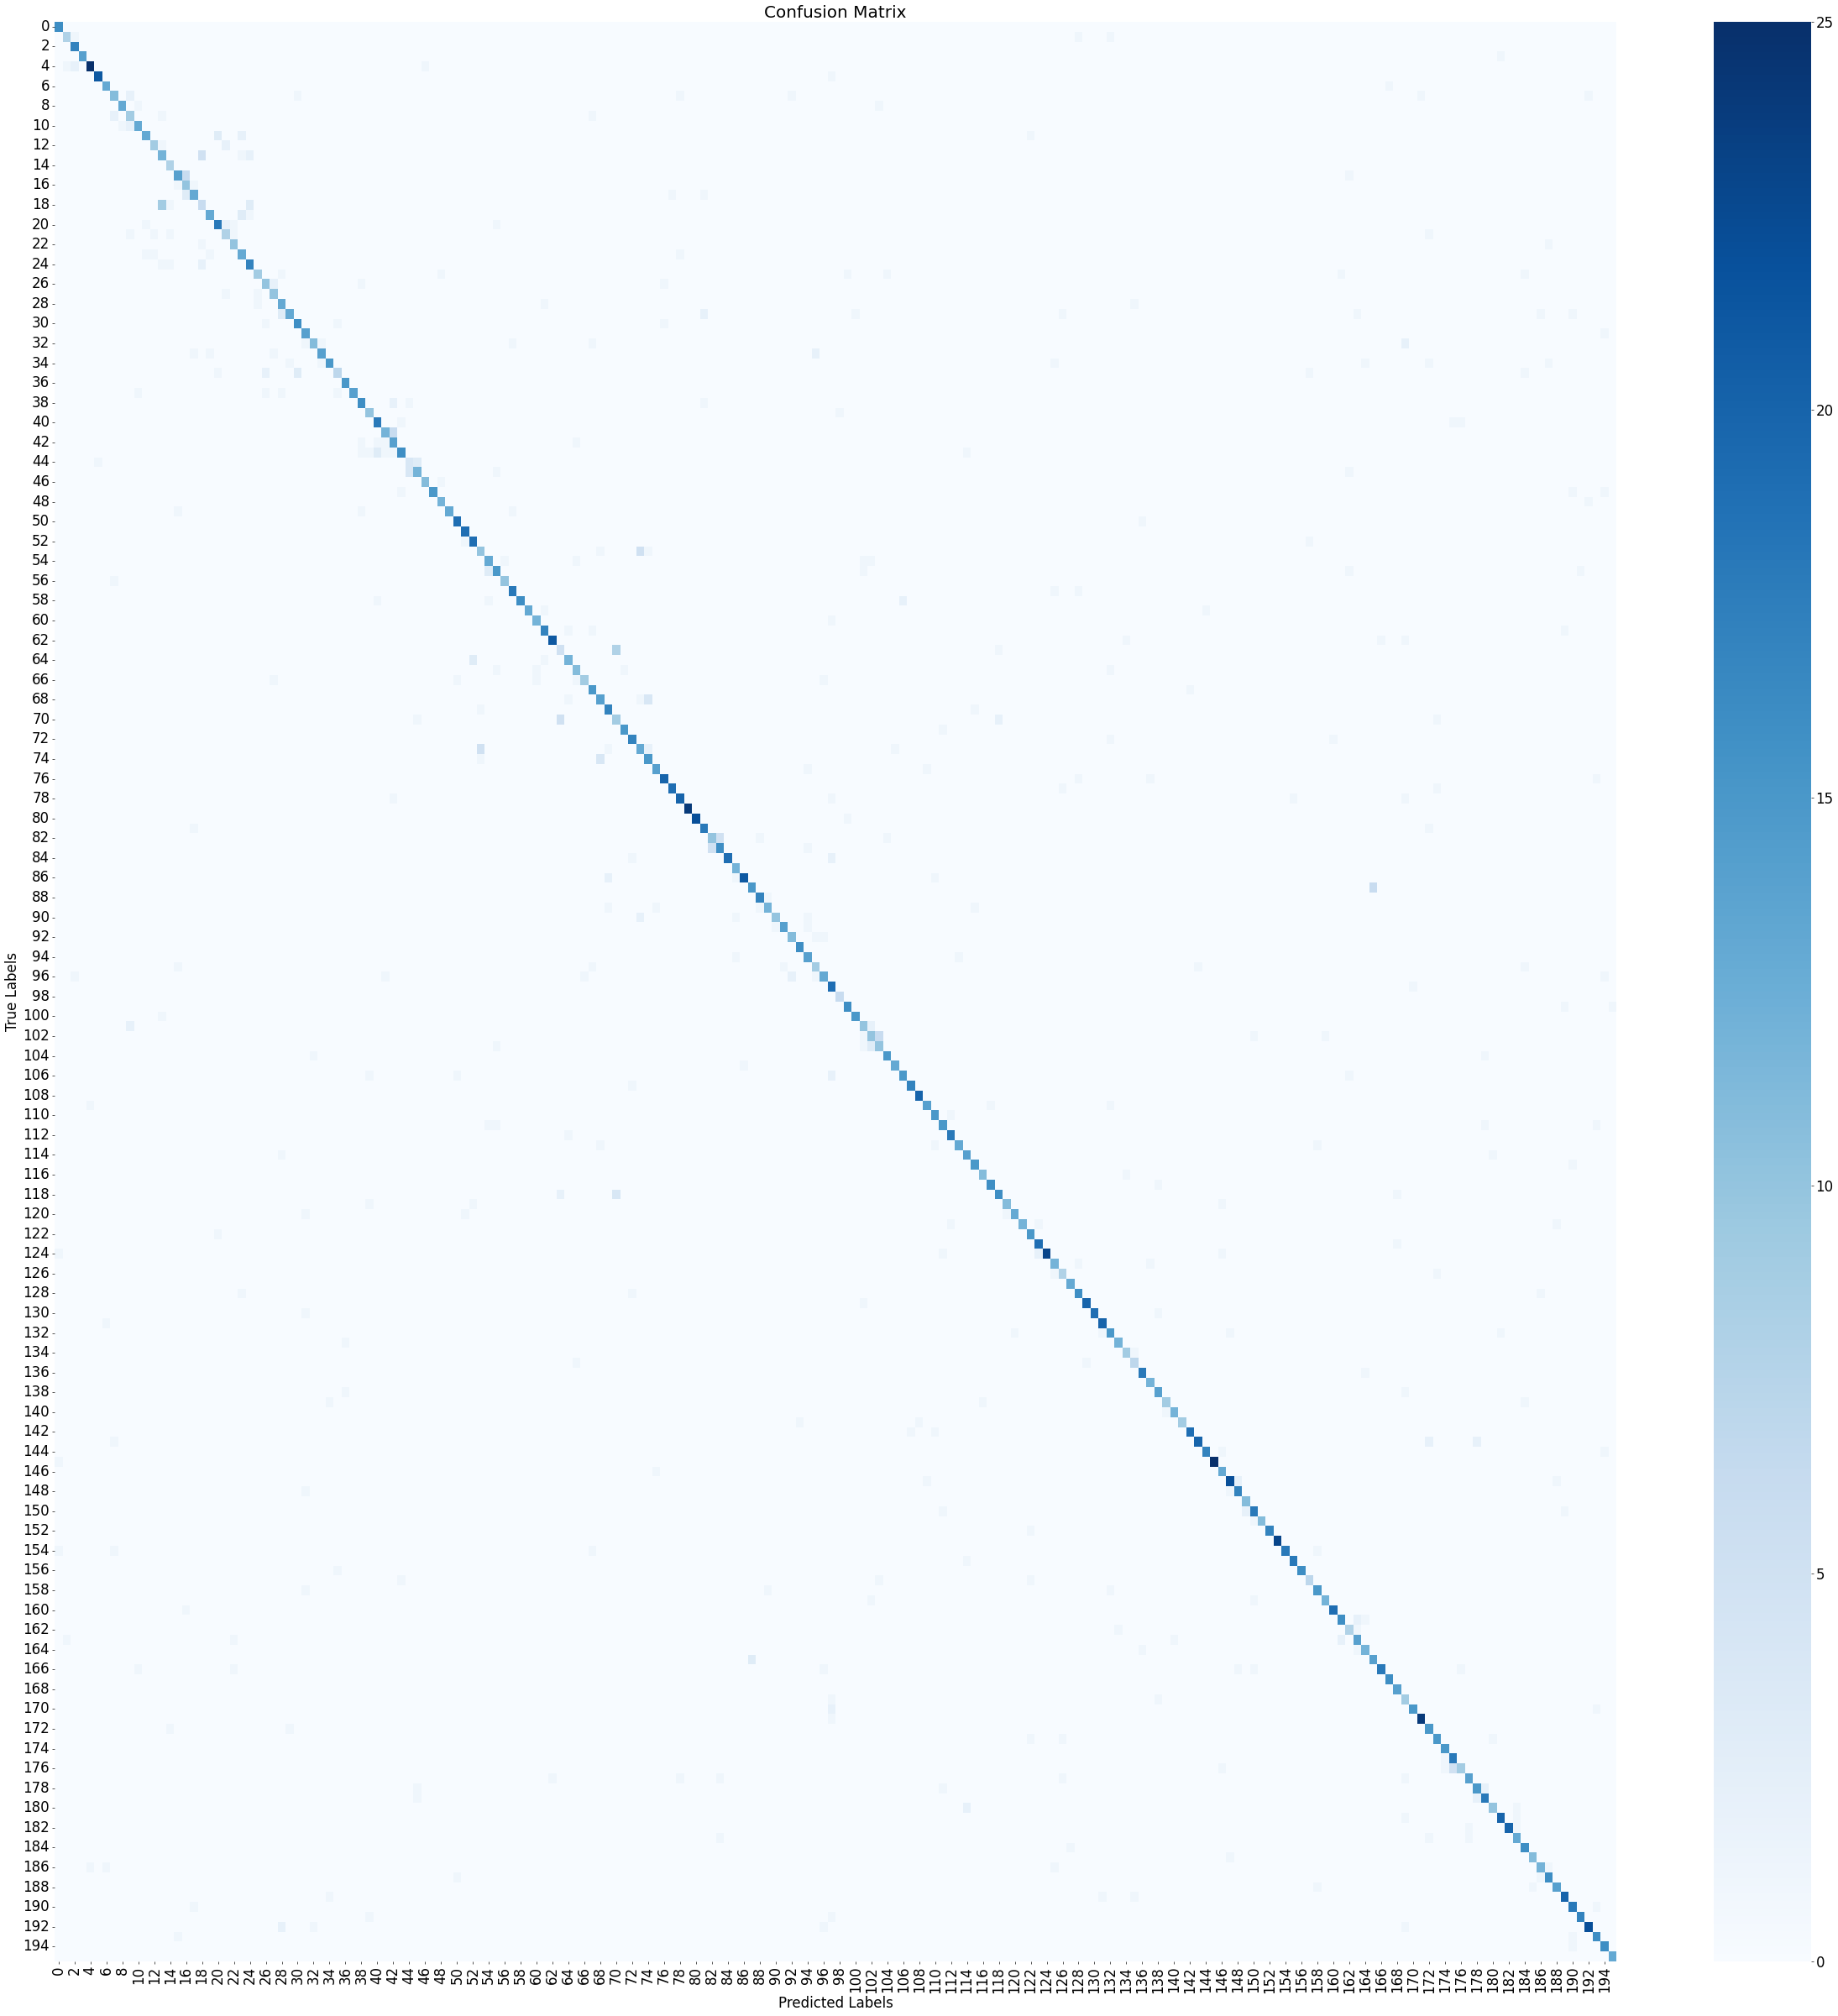

In [17]:
# Create a DataFrame for the confusion matrix
df_cm = pd.DataFrame(mc, index = [i for i in range (196)], columns = [i for i in range(196)])

# Plot the heatmap with the "Blues" colormap
plt.figure(figsize=(50, 50))
sn.heatmap(df_cm, cmap="Blues", annot=False)  # Set annot=False to remove annotations
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")

# Save the plot as a PNG image
plt.savefig('confusion_matrix.png')

# Show the plot
plt.show()

In [18]:
print("Classification report:")
print(cr)

Classification report:
                                                        precision    recall  f1-score   support

                            AM General Hummer SUV 2000       0.84      1.00      0.91        16
                                   Acura RL Sedan 2012       0.80      0.73      0.76        11
                                   Acura TL Sedan 2012       0.81      1.00      0.89        17
                                  Acura TL Type-S 2008       1.00      0.93      0.97        15
                                  Acura TSX Sedan 2012       0.93      0.86      0.89        29
                             Acura Integra Type R 2001       0.95      0.95      0.95        22
                              Acura ZDX Hatchback 2012       0.87      0.93      0.90        14
              Aston Martin V8 Vantage Convertible 2012       0.69      0.61      0.65        18
                    Aston Martin V8 Vantage Coupe 2012       0.93      0.87      0.90        15
                

## Explicabilité

### Fausses prédictions

In [19]:
# Use the unique() function to get unique class names
class_names = df_names.iloc[:, 0].unique()

# Convert class names to a list
class_names_list = class_names.tolist()

In [20]:
# Create a folder to save false images
false_images_folder = "false_images"
os.makedirs(false_images_folder, exist_ok=True)

# Iterate over the test dataset and make predictions
with torch.no_grad():
    for images, labels in val_loader:
        # Transfer the images and labels to the device
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        
        # Get the predicted labels
        _, predicted = torch.max(outputs, 1)
        
        # Convert tensors to numpy arrays
        labels_np = labels.cpu().numpy()
        predicted_np = predicted.cpu().numpy()
        
                
        # Find indices of false predictions
        false_indices = np.where(labels_np != predicted_np)[0]
        
        # Iterate over false predictions
        for idx in false_indices:
            # Get the image, predicted label, and true label
            image = images[idx].cpu()
            predicted_label = predicted_np[idx]
            true_label = labels_np[idx]

            # Get the class name for the true label
            true_class_name = class_names_list[true_label].strip()

            # Save the false image with the class name as the filename
            true_class_name = true_class_name.replace('/','-')
            filename = f"{true_class_name}_{idx}.png"
            torchvision.utils.save_image(image, os.path.join(false_images_folder, filename))

In [21]:
def get_false_images(target_string):
    # Get the list of filenames that contain the target string
    relevant_files = [filename for filename in os.listdir(folder_path) if target_string in filename]
    if len(relevant_files)==0:
        print("No false prediction for the class " + target_string)
        return
    
    # Calculate the number of rows and columns needed
    num_images = len(relevant_files)
    num_cols = 5
    num_rows = (num_images + num_cols - 1) // num_cols  # Round up to the nearest whole number

    # Create subplots with the calculated number of rows and columns, adjust figsize for larger images
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 4 * num_rows))

    # Reshape axs into a 2D array with the correct number of rows and columns
    axs = axs.reshape((num_rows, num_cols))

    # Iterate over relevant files and plot the images in the subplot grid
    for i, filename in enumerate(relevant_files):
        # Calculate the row and column index for the current subplot
        row_idx = i // num_cols
        col_idx = i % num_cols

        # Load the image
        image = Image.open(os.path.join(folder_path, filename))

        # Extract the index from the filename
        index = filename.split("_")[-1].split(".")[0]

        # Plot the image in the corresponding subplot
        axs[row_idx, col_idx].imshow(image, aspect='auto')  # Set aspect to 'auto' for preserving aspect ratio
        axs[row_idx, col_idx].set_title(index)  # Set the title to the index
        axs[row_idx, col_idx].axis("off")  # Remove axes

    # Hide empty subplots if the number of images is not a multiple of num_cols
    for i in range(num_images, num_rows * num_cols):
        row_idx = i // num_cols
        col_idx = i % num_cols
        fig.delaxes(axs[row_idx, col_idx])

    # Adjust layout and display the plot
    plt.tight_layout()
    print("False prediction for the class " + target_string)
    plt.show()

No false prediction for the class AM General Hummer SUV 2000
False prediction for the class Acura RL Sedan 2012


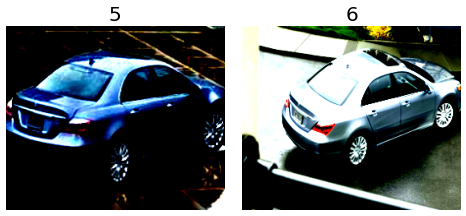

No false prediction for the class Acura TL Sedan 2012
False prediction for the class Acura TL Type-S 2008


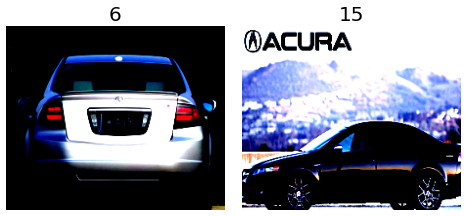

False prediction for the class Acura TSX Sedan 2012


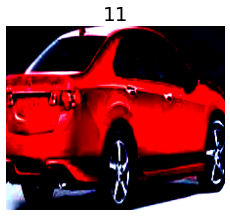

In [23]:
folder_path = '/kaggle/working/false_images'
for i in range(5):
    get_false_images(class_names_list[i])

### Zone d'importance

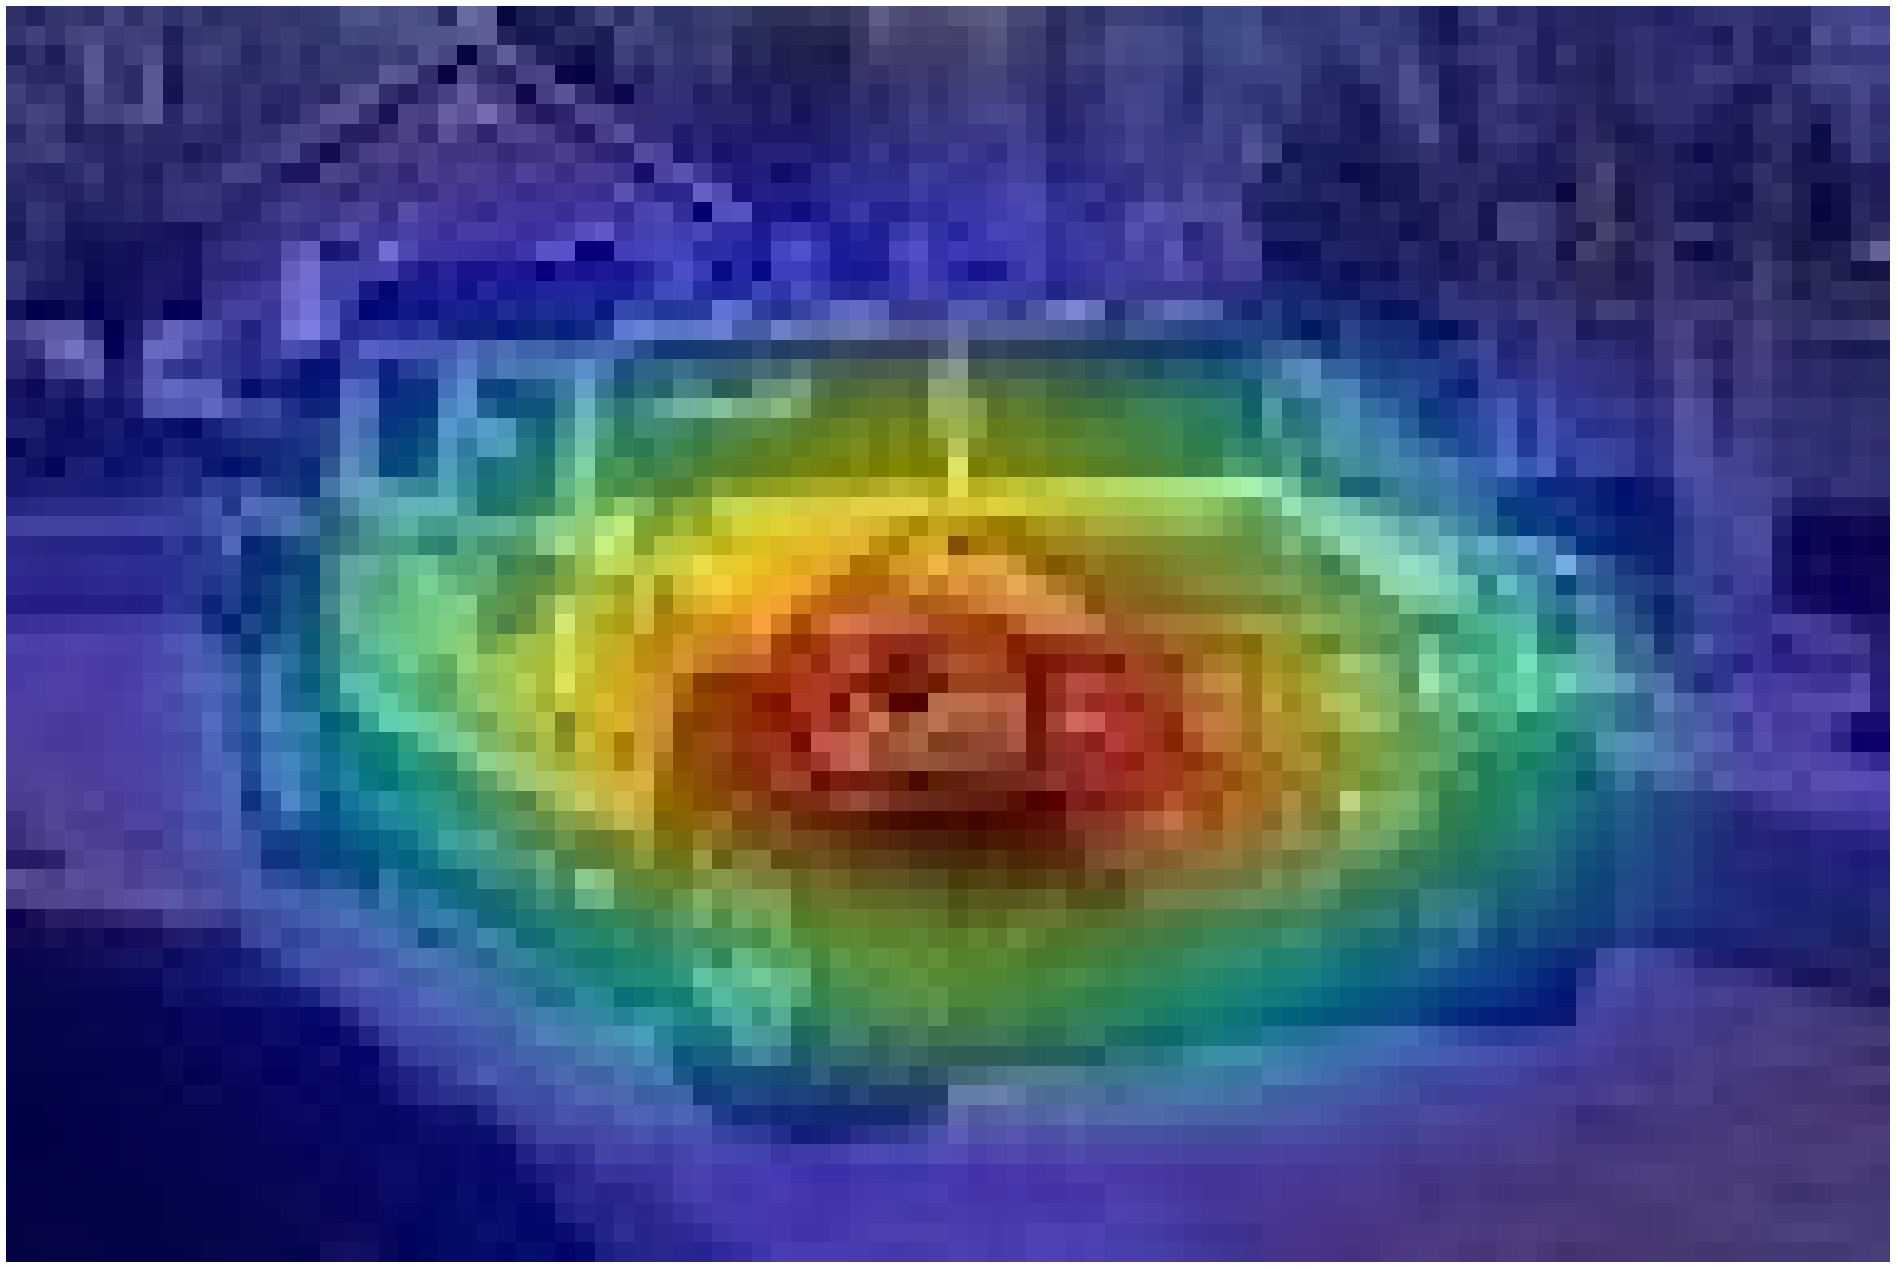

In [25]:
# Helper function to convert tensor to numpy array
def tensor_to_array(tensor):
    return tensor.detach().cpu().numpy()

# Function to overlay CAM as heatmap on image
def overlay_heatmap(img, mask, alpha=0.5, colormap=cm.jet):
    """Overlay the CAM heatmap on the image."""
    # Normalize the mask to ensure the values are between 0 and 1
    mask = mask - mask.min()
    mask = mask / mask.max()
    
    # Apply the colormap to convert the grayscale mask to a colored heatmap
    heatmap = colormap(mask)[:, :, :3]  # Take RGB channels only, ignore A channel from RGBA

    # Convert heatmap to an image
    heatmap_image = Image.fromarray((heatmap * 255).astype(np.uint8))

    # Resize heatmap to match image size
    heatmap_image = heatmap_image.resize(img.size, Image.LANCZOS)

    # Blend the heatmap with the original image
    blended_image = Image.blend(img, heatmap_image, alpha)
    return blended_image

model.eval()  # Use eval mode


# Load and preprocess the image
img_path = '/kaggle/input/stanford-car-dataset-by-classes-folder/car_data/car_data/test/AM General Hummer SUV 2000/00076.jpg'
img_pil = Image.open(img_path)
img = read_image(img_path)
input_tensor = normalize(resize(img, (224, 224)) / 255., [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

# Enable gradients on the input tensor
input_tensor.requires_grad_(True)

# Initialize CAM extractor
cam_extractor = SmoothGradCAMpp(model, target_layer='layer4')

# Process through the model and retrieve the CAM
out = model(input_tensor.unsqueeze(0).cuda())
activation_map = cam_extractor(out.squeeze(0).argmax().item(), out)

# Convert the CAM to heatmap and overlay on the image
cam_image = tensor_to_array(activation_map[0].squeeze(0))  # Convert CAM tensor to array
result = overlay_heatmap(img_pil, cam_image, alpha=0.5, colormap=cm.jet)  # Use the jet colormap

# Display the result
plt.imshow(result)
plt.axis('off')
plt.tight_layout()
plt.savefig('grad.png')
plt.show()

#### Pour les fausses prédictions

In [26]:
# Create a folder to save false images
false_images_with_heatmap = "false_images_with_heatmap"
os.makedirs(false_images_with_heatmap, exist_ok=True)

# Iterate over each file in the directory
for filename in os.listdir(false_images_folder_path):
    # Check if the file is an image file
    if filename.endswith(".jpg") or filename.endswith(".png"):
        # Load and preprocess the image
        img_path = os.path.join(false_images_folder_path, filename)
        img_pil = Image.open(img_path)
        img = read_image(img_path)
        input_tensor = normalize(resize(img, (244, 244)) / 255., [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

        # Enable gradients on the input tensor
        input_tensor.requires_grad_(True)

        # Initialize CAM extractor
        cam_extractor = SmoothGradCAMpp(model, target_layer='layer4')

        # Process through the model and retrieve the CAM
        out = model(input_tensor.unsqueeze(0).cuda())
        activation_map = cam_extractor(out.squeeze(0).argmax().item(), out)

        # Convert the CAM to heatmap and overlay on the image
        cam_image = tensor_to_array(activation_map[0].squeeze(0))  # Convert CAM tensor to array
        result = overlay_heatmap(img_pil, cam_image, alpha=0.5, colormap=cm.jet)  # Use the jet colormap

        # Save the result
        result.save(os.path.join(false_images_heatmap_folder_path, filename))

In [27]:
import shutil
from IPython.display import FileLink

# Define the directory to zip
DIRECTORY_TO_ZIP = '/kaggle/working/false_images_with_heatmap'

# Create a zip archive of the specified directory
shutil.make_archive('/kaggle/working/test', 'zip', DIRECTORY_TO_ZIP)

# Provide a download link for the zip file
FileLink(r'/kaggle/working/test.zip')

/kaggle/working/test.zip

In [28]:
import shutil
from IPython.display import FileLink

# Define the directory to zip
DIRECTORY_TO_ZIP = '/kaggle/working/false_images'

# Create a zip archive of the specified directory
shutil.make_archive('/kaggle/working/img', 'zip', DIRECTORY_TO_ZIP)

# Provide a download link for the zip file
FileLink(r'/kaggle/working/img.zip')

/kaggle/working/img.zip